#### Match up SST data with PACE data

In [4]:
import csv
import os
import glob

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import dask.array as da
from   dask.distributed import Client
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import matplotlib
import matplotlib.colors as colors
from matplotlib import lines
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker 
import cartopy.mpl.ticker as cticker
import pandas as pd
from matplotlib.widgets import TextBox
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA



#### Read Operational Mercator global ocean analysis and forecast data
https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/description

In [5]:
ssh = xr.open_dataset("cmems_mod_glo_phy_anfc_0.083deg_P1M-m_1754533186899.nc")
ssh["month"] = ssh.time.dt.month
ssh

<xarray.Dataset> Size: 140MB
Dimensions:    (time: 15, latitude: 1081, longitude: 1080)
Coordinates:
  * time       (time) datetime64[ns] 120B 2024-04-01 2024-05-01 ... 2025-06-01
  * latitude   (latitude) float32 4kB -30.0 -29.92 -29.83 ... 59.83 59.92 60.0
  * longitude  (longitude) float32 4kB -75.0 -74.92 -74.83 ... 14.75 14.83 14.92
Data variables:
    mlotst     (time, latitude, longitude) float32 70MB ...
    zos        (time, latitude, longitude) float32 70MB ...
    month      (time) int64 120B 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6
Attributes:
    Conventions:       CF-1.11
    title:             Monthly mean fields for product GLOBAL_ANALYSISFORECAS...
    institution:       Mercator Ocean
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MERCATOR GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy_anfc_0.083deg_P1M-m_202406
    subset:date:       2025-08-07T02:19:46.900Z

In [25]:
def compute_geos_current(ssh,lat):
    # adapt from Go-SWACE
    # https://github.com/mcornec/GO-SWACE/blob/main/compute_vorticity_strain.ipynb
    """
    ssh: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 8300,8300 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy

    # post process
    ind = np.abs(f_coriolis) < 1E-5
    ug[ind] = np.nan
    vg[ind] = np.nan
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

In [26]:
grid_lon, grid_lat = np.meshgrid(ssh.longitude, ssh.latitude)

In [27]:
ug, vg, geos_current = compute_geos_current(ssh.zos.values[0], grid_lat)

/tmp/ipykernel_1017/2865904803.py:19: RuntimeWarning: divide by zero encountered in divide
  vg = (gravity/np.array(f_coriolis))*dsdx
/tmp/ipykernel_1017/2865904803.py:20: RuntimeWarning: divide by zero encountered in divide
  ug = -(gravity/np.array(f_coriolis))*dsdy


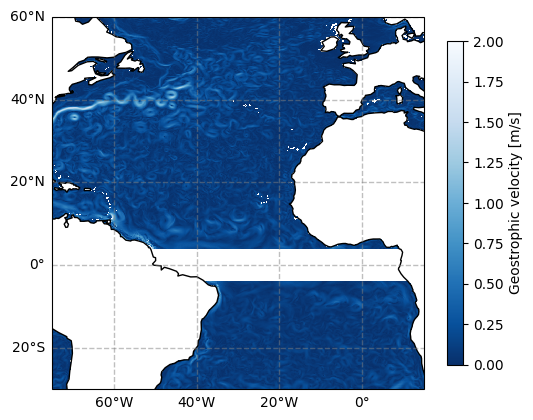

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# ssh reference to geoid
cbar_kwargs = {'shrink': 0.7, 'aspect': 20, 'pad': 0.05}
cbar = axs.pcolormesh(grid_lon, grid_lat, geos_current, vmin=0, vmax=2,
               cmap='Blues_r', transform=ccrs.PlateCarree())
plt.colorbar(cbar, ax=axs, **cbar_kwargs, label="Geostrophic velocity [m/s]")

axs.add_feature(cartopy.feature.COASTLINE)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Configure gridline labels
gl.top_labels = False
gl.right_labels = False


#### Read AMT28 transection

In [51]:
AMT_df = pd.read_csv('../Shailja/AMT28_underway_latlon.csv')
lats = AMT_df.Lat; lons = AMT_df.Lon
# filtering
ind = (lons>-75) & (lons<=15) & (lats>-30) & (lats<60)

In [48]:
# a random transection
sec_lon = -40.
sec_lat_max = 50
sec_lat_min = 20
# select data
ssh_sec = ssh.zos.sel(time="2024-07", longitude=sec_lon, method='nearest').sel(latitude=slice(sec_lat_min, sec_lat_max))

#### visualize it

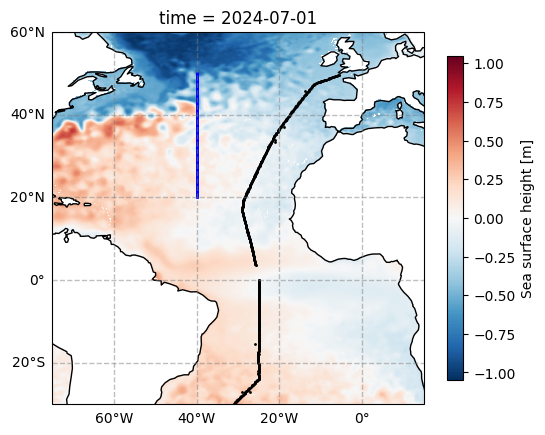

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})
# ssh reference to geoid
cbar_kwargs = {'shrink': 0.7, 'aspect': 20, 'pad': 0.05}
cbar = ssh.zos.sel(time="2024-07")[0].plot.imshow(ax=axs, cmap='RdBu_r', transform=ccrs.PlateCarree(),
                                                 cbar_kwargs=cbar_kwargs)
# draw transections
axs.scatter(lons[ind], lats[ind], s=1, c='k')
axs.scatter(sec_lon + ssh_sec.latitude * 0, ssh_sec.latitude, s=1, c='b')

axs.add_feature(cartopy.feature.COASTLINE)
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Configure gridline labels
gl.top_labels = False
gl.right_labels = False


#### Get SSH along the transaction

In [74]:
query_lats = lats[ind].values
query_lons = lons[ind].values
points = [ssh.zos.sel(latitude=i, longitude=j, method='nearest') for i, j in zip(query_lats, query_lons)]

Text(0.5, 1.0, 'transection at longitude=-40.0˚')

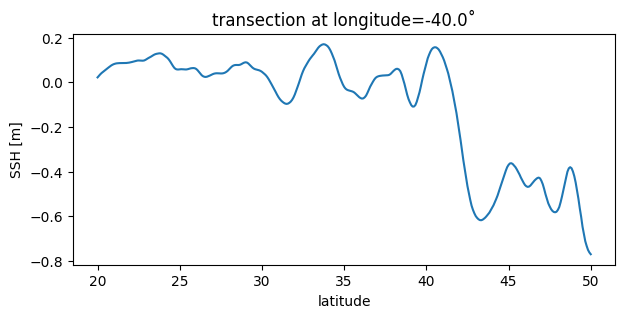

In [56]:
plt.subplots(figsize=(7,3))
plt.plot(ssh_sec.latitude, ssh_sec)
plt.xlabel("latitude")
plt.ylabel("SSH [m]")
plt.title(f"transection at longitude={sec_lon}˚")

Text(0, 0.5, 'SSH [m]')

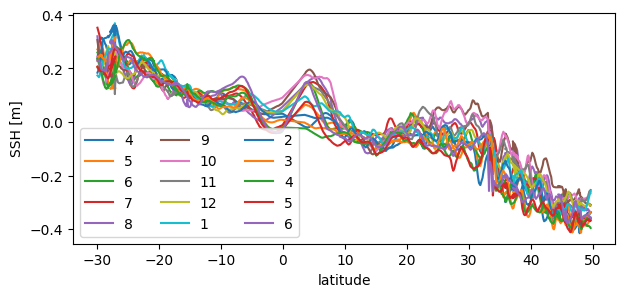

In [84]:
# plot 
month = ssh.time.dt.month.values
plt.subplots(figsize=(7,3))
plt.plot(query_lats, points, label=month)
plt.legend(ncols=3)
plt.xlabel("latitude")
plt.ylabel("SSH [m]")